In [55]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch import optim
from PIL import Image

In [56]:
## uncomment if using colab
#from google.colab import drive
#drive.mount('/content/drive')

In [57]:
## uncomment if using colab
#! unzip "drive/My Drive/Kmodel/Copy of Test.zip"

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #GPU training
device

device(type='cuda')

In [59]:
SOS = 0 #start of sequence
EOS = 1 #end of sequence

In [60]:
import os
files = os.listdir("../side_utils/DataGen/Data/WordPics/")

In [61]:
files.sort(key=lambda x:int(x.split(".")[0]))

In [62]:
with open("../side_utils/DataGen/Data/labels.txt", encoding="utf8") as f:
    chars = f.readlines()

In [63]:
import numpy as np
#check if file names and labels are same
assert (np.array([int(i.split(":")[0]) for i in chars]) == np.array([int(i.split(".")[0]) for i in files])).all()

In [64]:
chars = list(map(lambda x:x.split(":")[-1].strip(), chars))
chars[:10]

['محمد',
 'پوٚت',
 'میلنہٕ',
 'شفا',
 'گواطمینانِ',
 'فلک',
 'قدر،',
 'بۅڈ',
 'تا',
 'ووتھ']

In [65]:
chars = list(set("".join(chars)))

In [66]:
index2word = dict(enumerate(chars,2)) # start from 2, because 0 and 1 are reserved
index2word[0] = "SOS"
index2word[1] = "EOS"

In [67]:
word2index = {v:k for k,v in index2word.items()}

In [68]:
len(word2index)

114

In [20]:
os.makedirs("../side_utils/DataGen/Data/train_data", exist_ok=True)
os.makedirs("../side_utils/DataGen/Data/val_data", exist_ok=True)
os.makedirs("../side_utils/DataGen/Data/test_data", exist_ok=True)


In [16]:
train_size = 20000
val_size = 5000

In [17]:
import shutil

In [20]:
f1 = open("../side_utils/DataGen/Data/labels.txt", encoding="utf8")
f2 = open("../side_utils/DataGen/Data/labels_train.txt", "a", encoding="utf8")

for file in files[:train_size]:
    shutil.copyfile("../side_utils/DataGen/Data/WordPics/"+file,"../side_utils/DataGen/Data/train_data/"+file)

    f2.write(f1.readline())
f2.close()

In [21]:
# f1 = open("labels.txt", encoding="utf8")
f3 = open("../side_utils/DataGen/Data/labels_val.txt", "a", encoding="utf8")

for file in files[train_size:train_size+val_size]:
    shutil.copyfile("../side_utils/DataGen/Data/WordPics/"+file,"../side_utils/DataGen/Data/val_data/"+file)

    f3.write(f1.readline())
f3.close()

In [22]:
# f1 = open("labels.txt", encoding="utf8")
f4 = open("../side_utils/DataGen/Data/labels_test.txt", "a", encoding="utf8")

for file in files[train_size+val_size:]:
    shutil.copyfile("../side_utils/DataGen/Data/WordPics/"+file,"../side_utils/DataGen/Data/test_data/"+file)

    f4.write(f1.readline())
f4.close()
f1.close()

In [69]:
import os
import cv2
class WordDataset(Dataset):
    
    def __init__(self, root_folder, labels_path, transform=None):
        self.transform = transform
        self.root_folder = root_folder
        self.files = os.listdir(root_folder)
        self.files.sort(key=lambda x:int(x.split(".")[0]))
        with open(labels_path) as f:
            self.labels = f.readlines()
            self.labels = self.labels
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
#         image = cv2.imread(os.path.join(self.root_folder, self.files[idx]), 0)
        image = Image.open(os.path.join(self.root_folder, self.files[idx]))
#         image = (255-image[:,::-1])/255
#         label_no = self.files[idx].split(".")[0]
        label = self.labels[idx].split(":")[-1].strip()
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [70]:
transform = transforms.Compose([transforms.Grayscale(3),
                                transforms.RandomRotation(15, fill=255), # add an issue in torchvision
                                transforms.RandomAffine(20,fillcolor=(255,255,255)),
                                transforms.ColorJitter(brightness=0.5, contrast=0.5),
                                transforms.ToTensor(),])
#                                 transforms.Normalize(mean=[0.06333], std=[1.4219])])

transform2 = transforms.Compose([transforms.Grayscale(3),
                                transforms.ToTensor(),])

In [71]:
# dataset = WordDataset("./WordPics","./labels.txt", transform)
train_dataset = WordDataset("../side_utils/DataGen/Data/train_data",
                            "../side_utils/DataGen/Data/labels_train.txt", transform)
val_dataset = WordDataset("../side_utils/DataGen/Data/val_data",
                          "../side_utils/DataGen/Data/labels_val.txt", transform)
test_dataset = WordDataset("../side_utils/DataGen/Data/test_data",
                           "../side_utils/DataGen/Data/labels_test.txt", transform2)


In [72]:
train_dl = DataLoader(train_dataset,batch_size=1,num_workers=0, shuffle=True)
val_dl = DataLoader(val_dataset,batch_size=1,num_workers=0, shuffle=True)
test_dl = DataLoader(test_dataset,batch_size=1,num_workers=0, shuffle=True)


> Think of some way to put an **EOS** in the encoder. While i currently think it is not necessary, or that encoder and decoder need not have the same **EOS**.

Check if a random image is correctly labelled with the label

('سپدٕۍمٕتۍ،',)


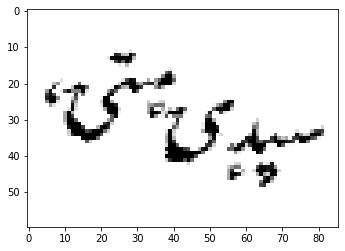

In [73]:
iterator = iter(train_dl) # change to train_dl or val_dl to check in those datasets
image, label = iterator.next()
import matplotlib.pyplot as plt
print(label)
plt.imshow(image[0].transpose(0,1).transpose(1,2))

# Models

The model architechture is organized into three modules:
1. `ImgEncoder`: A convolutional network. 
  -  It will take input of an image of `[1, 60, x]` (channels, height, width) and produce the output of `[128, 12, x']`, which is then flattened out to `[1536, x']`.

2. `Encoder(input_size, hidden_size, n_layers)`: 
  - It has a linear layer followed by a GRU layer.
  - It takes a vector of `[1, input_size]` and the linear converts into `[1, hidden_size]` vector. 
  - Then the `[1, hidden_size]` vector is passed via a GRU with `n_layers`.
  - The hidden input to GRU is initialized as zeros.

3. `DecoderRNN(hidden_size, output_size, n_layers)`: 
   - It has an embedding layer giving out `hidden_size` length of vectors.
   - Then a GRU layer with `hidden_size` output and `n_layers`.
   - Then a linear layer of `output_size` nodes.
   - Then a softmax.

In [74]:
class ImgEncoder(nn.Module):
    def __init__(self):
        super(ImgEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=3)
        self.conv2 = nn.Conv2d(16,32,kernel_size=3)        
        self.conv3 = nn.Conv2d(32,64,kernel_size=3)
        self.conv4 = nn.Conv2d(64,128,kernel_size=3)
 
        
        self.pool = nn.MaxPool2d((2,2))
        self.flatten = nn.Flatten(end_dim=-2)
        
        
        ,
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        
        x = self.pool(x)
       
        
        x = self.flatten(x)
        
        
        
        return x

In [75]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers):
        
        super(Encoder, self).__init__()

        self.n_layers = n_layers
 
        self.hidden_size = hidden_size
        
        self.fc1 = nn.Linear(input_size,hidden_size)
        
        
#         self.em = nn.Embedding(input_size,hidden_size)
        self.gru = nn.GRU(hidden_size,hidden_size,num_layers=n_layers)
    
    def forward(self, input, hidden):
        
        output = F.relu(self.fc1(input)).view(1,1,-1)
        
#         embedded = self.em(input).view(1,1,-1)
#         output = embedded
        output, hidden = self.gru(output, hidden)
        
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size, device=device)

In [76]:
class DecoderRNN(nn.Module):
    
    def __init__(self, hidden_size, output_size, n_layers):
        
        super(DecoderRNN, self).__init__()
 
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.em = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=n_layers)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        out = self.em(input).view(1,1,-1)
        out = F.relu(out)
        out, hidden = self.gru(out, hidden)
        out = self.softmax(self.out(out[0]))
        return out, hidden
    
    def initHidden(self):
        return torch.zeros(self.n_layers,1, self.hidden_size, device=device)

We will add the `EOS` to every label to denote the end of that vector.

In [77]:
def get_target(word):
    """This function converts a label into a target. It also adds `EOS` at the end."""
    t = [word2index[i] for i in word]
    t.append(EOS)
    return torch.tensor(t, dtype=torch.long, device=device).view(-1,1)

In [78]:
def train(image, label, conv, enc, dec, conv_optim, enc_optim, dec_optim, criterion):
    
    
    loss=0 


    # set gradients of every optimizers to be zero
    conv_optim.zero_grad()
    enc_optim.zero_grad()
    dec_optim.zero_grad()
 
    image = image.to(device)
    conv_output = conv(image) # move through conv part
    # conv_output shape will be [1,1536, x']
    
    
    enc_hidden = enc.initHidden() 
    

    # pass each of the [1, 1536] vectors to encoder
    for idx in range(conv_output.shape[2]): # for every 
        enc_out, enc_hidden = enc(conv_output[:,:,idx], enc_hidden)
 
    target = get_target(label[0]) # makes a tensor and adds EOS
    target_len = len(target)
    target.to(device)
 
 
    decoder_input = torch.tensor([[[SOS]]], device=device)

    # the output of encoder is now hidden input for decoder
    decoder_hidden = enc_hidden 


    for di in range(target_len):
        decoder_output, decoder_hidden = dec(decoder_input, decoder_hidden)
        topv, topi = decoder_output.topk(1) # get the top output
        decoder_input = topi.squeeze().detach()  # detach from history as input
 
        loss += criterion(decoder_output, target[di])

        # if decoder spits out EOS, stop.
        if decoder_input.item() == EOS:
            break
    
    # compute gradients for loss
    loss.backward()
 
    # update weights 
    conv_optim.step()
    enc_optim.step()
    dec_optim.step()
    
    return loss.item()/target_len


In [79]:
def validate(image, label, conv, enc, dec, crterion):
    loss=0

    image = image.to(device)
    conv_output = conv(image)
 
    enc_hidden = enc.initHidden()
    
    for idx in range(conv_output.shape[2]):
        enc_out, enc_hidden = enc(conv_output[:,:,idx], enc_hidden)
 
    target = get_target(label[0])
    target_len = len(target)
    target.to(device)
 
 
    decoder_input = torch.tensor([[[SOS]]], device=device)
    decoder_hidden = enc_hidden

 
    for di in range(target_len):
        decoder_output, decoder_hidden = dec(decoder_input, decoder_hidden)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input
 
        loss += criterion(decoder_output, target[di])
        if decoder_input.item() == EOS:
            break
    
    return loss.item()/target_len
    

In [80]:
learning_rate = 0.01
conv = ImgEncoder()
enc = Encoder(1536,256,3)
dec = DecoderRNN(256, len(word2index),3)
criterion = nn.NLLLoss()
enc_optim = optim.SGD(enc.parameters(), lr=learning_rate, momentum=0.9)
dec_optim = optim.SGD(dec.parameters(), lr=learning_rate, momentum=0.9)
conv_optim = optim.SGD(conv.parameters(), lr=learning_rate, momentum=0.9)

In [81]:

# nn.GRU()
# criterion()
len(word2index)

114

In [82]:
main_path = "drive/My Drive/Kmodel/" 

# conv.load_state_dict(torch.load(main_path+"conv2.pt"))
# enc.load_state_dict(torch.load(main_path+"enc2.pt"))
# dec.load_state_dict(torch.load(main_path+"dec2.pt"))

conv = conv.to(device)
enc = enc.to(device)
dec = dec.to(device)

In [83]:
n_epochs = 6

In [84]:
print_every = 5000
i=0


for epoch in range(n_epochs):

    # set the models in train mode
    conv.train()
    enc.train()
    dec.train()

    total_loss = 0
    for image, label in train_dl:
        if image.shape[3] < 20:
            continue
        err = train(image, label, conv, enc, dec,
              conv_optim, enc_optim, dec_optim, criterion)
        total_loss+=err
        if i%print_every ==0:
            print("Current Error: ",err)
        i+=1
    # if epoch%100==0:
    print("Epoch", epoch, "Avg Train Error: ", total_loss/len(train_dl))
    # inp = input("Change Learning rate?")
    # if inp.casefold() == 'y':
    #   learning_rate = float(input("Enter Learning rate"))
    #   enc_optim = optim.Adam(enc.parameters(), lr=learning_rate)#, momentum=0.9)
    #   dec_optim = optim.Adam(dec.parameters(), lr=learning_rate)#, momentum=0.9)
    #   conv_optim = optim.Adam(conv.parameters(), lr=learning_rate)#, momentum=0.9)

    # print("saving models")
    # torch.save(conv.state_dict(), main_path+"conv.pt")
    # torch.save(enc.state_dict(), main_path+"enc.pt")
    # torch.save(dec.state_dict(), main_path+"dec.pt")


    ################################################
    # evalualtion mode
    conv.eval()
    enc.eval()
    dec.eval()
    eval_loss = 0

    for image, label in val_dl:
        if image.shape[3] < 20:
            continue
        err = validate(image, label, conv, enc, dec, criterion)
        eval_loss += err
    print("Epoch", epoch, "Avg Val Error: ", eval_loss/len(val_dl))
    
  


Current Error:  4.761396408081055


KeyboardInterrupt: 

Test your model now

In [0]:
conv.eval()
enc.eval()
dec.eval()

preds = []
tars = [] # targets

for image, label in test_dl:
    if image.shape[3] < 20:
        continue

    image = image.to(device)

    conv_output = conv(image)
 
    enc_hidden = enc.initHidden()
 
    for idx in range(conv_output.shape[2]):
        enc_out, enc_hidden = enc(conv_output[:,:,idx], enc_hidden)
 
    target = get_target(label[0])
    target_len = len(target)

    tars.append(target.detach().cpu().numpy().reshape(1,-1))
 
 
 
    decoder_input = torch.tensor([[[SOS]]], device=device)
    decoder_hidden = enc_hidden
 
    # print("actual: ",label[0], "predicted: ",end="")
    current_pred = []
    
    while True: # run until you hit EOS
        decoder_output, decoder_hidden = dec(decoder_input, decoder_hidden)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input
        current_pred.append(decoder_input.item())
 
        if decoder_input.item() == EOS:
                break
        # print(index2word.get(decoder_input.item(),"None"),end="")
    preds.append(np.array(current_pred))

    # print()

In [0]:
import numpy as np

def levenshtein(seq1, seq2):
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
    # print (matrix)
    return (matrix[size_x - 1, size_y - 1])

In [0]:
new_tars = []
for e in tars:
  try:
    len(e.squeeze())
    new_tars.append(e.squeeze())
  except TypeError:
    new_tars.append(np.array([e.squeeze()]))

In [0]:
dists = [levenshtein(i,j) for i, j in zip(preds, new_tars)]

In [0]:
from collections import Counter

In [0]:
c = Counter(dists)

In [0]:
c

Counter({0.0: 1049,
         1.0: 696,
         2.0: 438,
         3.0: 210,
         4.0: 96,
         5.0: 45,
         6.0: 18,
         7.0: 19,
         8.0: 7,
         9.0: 5,
         10.0: 5,
         11.0: 1,
         14.0: 2})

In [0]:
test_loss = 0
for image, label in test_dl:
    if image.shape[3] < 20:
        continue
    err = validate(image, label, conv, enc, dec, criterion)
    test_loss += err
print("Test loss: ", eval_loss/len(test_dl))
  

Test loss:  1.388873596909713


In [0]:
len(test_dl)

2600